# Goal

Create vectors from some Shakespeare text

In [3]:
import codecs #Word encoding
import glob #Regex
import multiprocessing #Concurrency
import os #Dealing ops with system
import pprint #Pretty printing
import re #Regular expression
import nltk #NLP library
import gensim.models.word2vec as w2v #Word2Vec
import sklearn.manifold #Dimensionality reduction
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Step 1 - Process our data

In [4]:
nltk.download('punkt') #Pretrained tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Get the book names, matching txt file

In [5]:
filenames = ['tiny_shakespeare.txt']
filenames

['tiny_shakespeare.txt']

In [6]:
corpus_raw = u""
for filename in filenames:
    print('Reading %s' % filename)
    with codecs.open(filename,'r','utf-8') as file:
        corpus_raw += file.read()
    print('Corpus in now %d characters long' % len(corpus_raw))
    print()

Reading tiny_shakespeare.txt
Corpus in now 1115394 characters long



## Step 2 - Split the corpus into sentences

In [7]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [8]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [9]:
print('There are %d sentences' % len(raw_sentences))

There are 12460 sentences


Convert into a list of words

In [10]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-z]"," ",raw)
    words = clean.split()
    return words

In [11]:
#Sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if(len(raw_sentence) > 0):
        sentences.append(sentence_to_wordlist(raw_sentence))

In [12]:
print('Example:')
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Example:
First Citizen:
First, you know Caius Marcius is chief enemy to the people.
['First', 'Citizen', 'First', 'you', 'know', 'Caius', 'Marcius', 'is', 'chief', 'enemy', 'to', 'the', 'people']


In [14]:
token_count = sum([len(sentence) for sentence in sentences])
print('The book corpus contains %d tokens' % token_count)

The book corpus contains 208503 tokens


## Step 3 - Train Word2Vec

Once we have vectores, 3 main tasks:
 - Distance
 - Similarity
 - Ranking
 
Let's define some hyperparameters

In [16]:
#Dimensionality of the resulting vectores
num_features = 2

#Minimum count threshold
min_word_count = 3

#Number of threads to run in parallel
num_workers = multiprocessing.cpu_count() #Returns the number of CPUs in the system

#Context windows size
context_size = 7

#Downsample setting for frequent words
downsampling = 1e-3 #Not see too many times the most frequent words...

#Seed for the randomnessss, to make results reproducible
seed = 1

In [24]:
shakespeare2Vec = w2v.Word2Vec(sg=1,
                           seed=seed,
                           workers=num_workers,
                           size=num_features,
                           min_count=min_word_count,
                           window=context_size,
                           sample=downsampling
)

In [25]:
shakespeare2Vec.build_vocab(sentences)

In [26]:
print('Word2Vec vocabulary length: %d' % shakespeare2Vec.corpus_count)

Word2Vec vocabulary length: 12460


# Step 4 - Train the model

In [28]:
shakespeare2Vec.train(sentences=sentences,total_examples=shakespeare2Vec.corpus_count,epochs=shakespeare2Vec.iter)

784806

**Yay, save to file!**

In [30]:
shakespeare2Vec.save('shakespeare2vec.w2v')

## Step 5 - Explore the trained model

In [60]:
shakespeare2Vec = w2v.Word2Vec.load('shakespeare2vec.w2v')

Compress for visualization

In [44]:
tsne = sklearn.manifold.TSNE(n_components=2,random_state=0)

In [52]:
all_word_vectors_matrix = shakespeare2Vec.syn1neg

In [54]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [55]:
print('Sample - Extended dimensionality\n%s' % all_word_vectors_matrix[0])
print('Sample - Reduced dimensionality\n%s' % all_word_vectors_matrix_2d[0])

Sample - Extended dimensionality
[ 1.26367939 -0.55275375]
Sample - Reduced dimensionality
[ 10.59808044  -2.45665165]


#### Plot time

In [69]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[shakespeare2Vec.wv.vocab[word].index])
            for word in shakespeare2Vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [70]:
points.head()

,word,x,y
0,thinking,-3.497799,-12.903875
1,hound,-0.277005,13.150306
2,begging,-10.118984,7.036099
3,become,-5.948298,7.066496
4,Hic,5.266455,-3.911742


In [77]:
import seaborn as sns
%pylab inline
sns.set_context('poster')

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


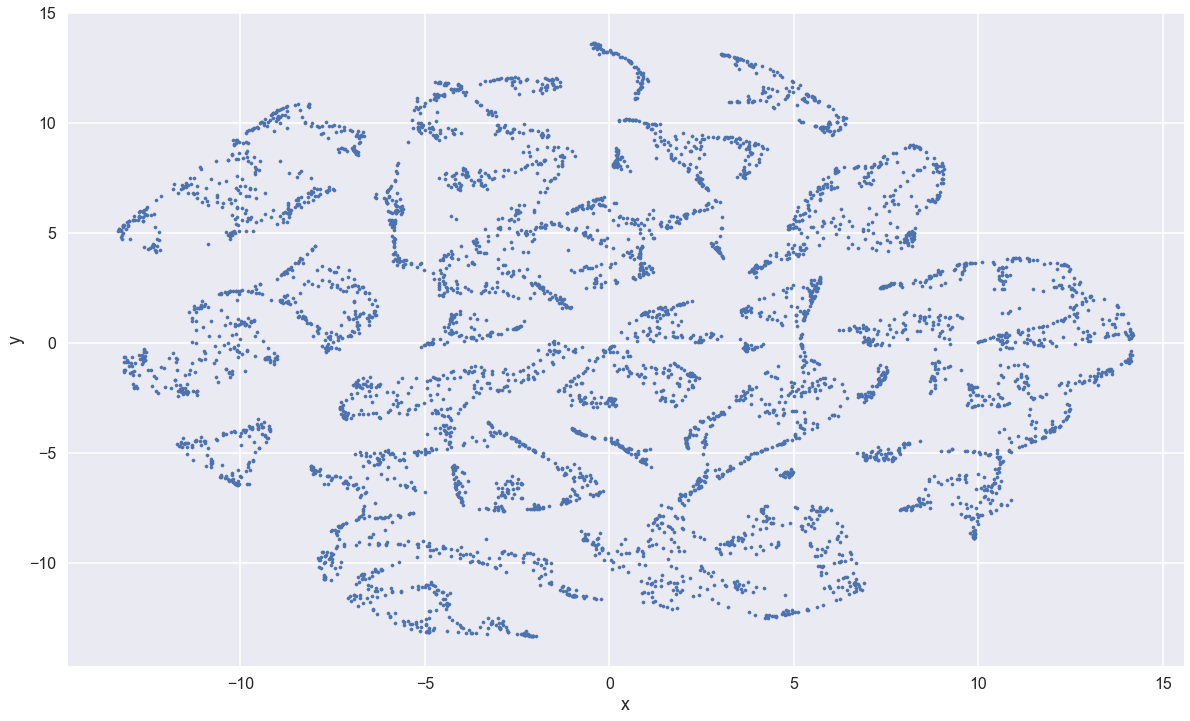

In [79]:
points.plot.scatter('x','y',s=10,figsize=(20,12));

### Zoom in to some interesting places

In [86]:
def plot_region(x_bounds,y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter('x','y',s=50,figsize=(10,8))
    for i,point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word,fontsize=11)

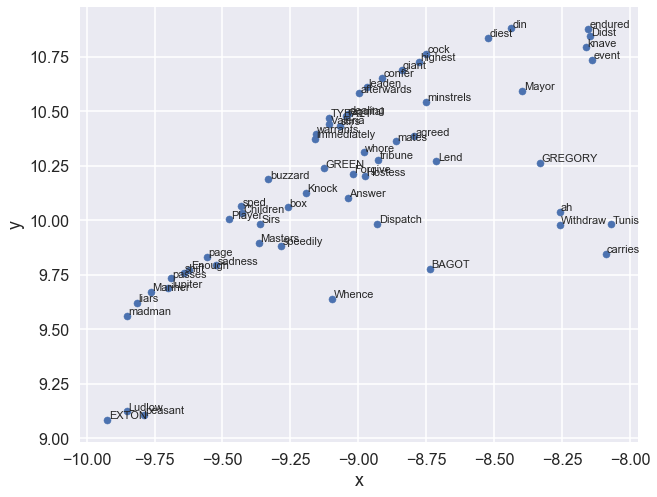

In [88]:
plot_region(x_bounds=(-10,-8),y_bounds=(9,11))

### Explore semantic similarities

In [94]:
shakespeare2Vec.most_similar("queen")

[('murderous', 1.0),
 ('puissant', 1.0),
 ('charm', 1.0),
 ('Farewell', 1.0),
 ('reasonable', 1.0),
 ('root', 0.9999999403953552),
 ('ordinance', 0.9999998211860657),
 ('divide', 0.9999997615814209),
 ('suffering', 0.9999997615814209),
 ('notorious', 0.9999997615814209)]

In [95]:
def nearest_similarity_cosmul(start1,end1,end2):
    similarities = shakespeare2Vec.most_similar_cosmul(
        positive = [end2,start1,],
        negative = [end1]
    )
    start2 = similarities[0][0]
    
    print('%s is related to %s as %s is related to %s' %(start1,end1,start2,end2))
    return start2

In [100]:
nearest_similarity_cosmul("queen","rich","poor")

queen is related to rich as George is related to poor


'George'